In [5]:
from scipy import ndimage
from scipy import misc
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import imageio
import glob
import numpy as np
import time
import cv2

import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def threshold(x):
    if x > 30:
        return 1
    else:
        return 0

#image = imageio.imread("test_img/out-0024.jpg")


#read the filepaths and sort them
filePaths = []
for filePath in glob.glob("test_img/*.jpg"):
    filePaths.append(filePath)
    
filePaths.sort()

#create np array for images.
#TODO find a better way to determine array size
images = np.zeros((len(filePaths), 360, 640))


#write the images into the np array
for i in range(len(filePaths)):
    image = imageio.imread(filePaths[i])
    grayImage = rgb2gray(image)
    #print(np.shape(image))
    #print(grayImage)
    images[i] = grayImage


    


imageDiffs = np.zeros(np.shape(images))
thresholdImages = np.zeros(np.shape(images))

for i in range(len(images) - 1):
    imageDiffs[i] = np.subtract(images[i], images[i+1])
    thresholdImages[i] = [list(map(threshold, x)) for x in imageDiffs[i]]



Show the plots

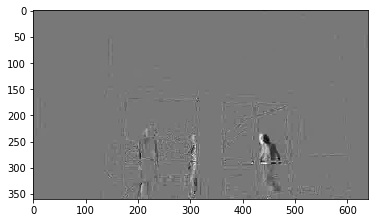

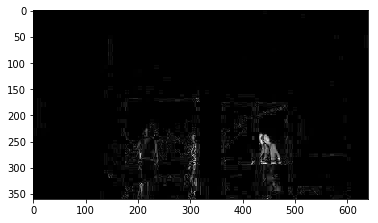

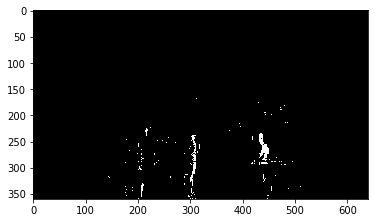

In [6]:
pictureNum = 60

plt.figure()
plt.imshow(imageDiffs[pictureNum], cmap="gray")
plt.figure()
plt.imshow(np.absolute(imageDiffs[pictureNum]), cmap="gray")
plt.figure()
plt.imshow(thresholdImages[pictureNum], cmap="gray")

1686


(360, 0)

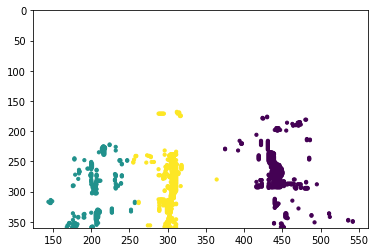

In [7]:
X = []
current = thresholdImages[60]

for i in range(len(current)):
    for j in range(len(current[0])):
        if current[i][j] == 1:
            X.append([i, j])

print(len(X))
#print(X)

X = np.array(X)
n_clusters = 3

#clustering = AgglomerativeClustering().fit(clusteringData)
#clustering = AffinityPropagation(convergence_iter=30).fit(clusteringData)
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
Y = kmeans.predict(X)

#print(Y)
#print(clustering.labels_)

#print(X[:, 0])
#print(X[:, 1])
plt.scatter(X[:, 1], X[:, 0], c=Y, s=10)
plt.ylim(360, 0)

In [20]:
clusteredX = []
for i in range(n_clusters):
    clusteredX.append([])
    
print(len(clusteredX))
for i in range(len(Y)):
    clusteredX[Y[i]].append(X[i])
    
for i in range(len(clusteredX)):
    currentCluster = np.array(clusteredX[i])
    xmin = np.amin(currentCluster[:, 1])
    xmax = np.amax(currentCluster[:, 1])
    ymin = np.amin(currentCluster[:, 0])
    ymax = np.amax(currentCluster[:, 0])
    print("Bounding rectangle for " + str(i) + ": X-Dimenstion: " + str(xmin) + "-" + str(xmax) + 
          ", Y-Dimenstion: " + str(ymin) + "-" + str(ymax))

3
Bounding rectangle for 0: X-Dimenstion: 375-542, Y-Dimenstion: 176-359
Bounding rectangle for 1: X-Dimenstion: 144-257, Y-Dimenstion: 222-359
Bounding rectangle for 2: X-Dimenstion: 255-364, Y-Dimenstion: 168-359


In [19]:
crazyImg = cv2.imread("test_img/out_0060.jpg")

cv2.rectangle(crazyImg, (0, 0), (100, 100), (0, 255, 255), 0, 8)
print("2")
#cv2.imwrite("test_img/lalala.png", crazyImg)


2
